# Lake-size distribution (LSD) scale comparison.

Goal: to load lake maps from the same region at two scale (HR and LR) and predict the small water body coverage (defined as area < 0.001 or 0.01 km2) from the LR dataset and physiographic region (with uncertainty).

Steps:
1. plot both LSD as survivor functions in log-log space (see functions from TGRS paper)

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as colorsa
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage as ndi 
from scipy.io import loadmat
from scipy.stats import binned_statistic
import pandas as pd
import geopandas as gpd
import pyogrio
import powerlaw
from tqdm import tqdm
## Plotting style
# plt.style.use('/mnt/c/Users/ekyzivat/Dropbox/Python/Matplotlib-rcParams/presentation.mplstyle')
# %matplotlib inline

## Plotting params
sns.set_theme('notebook', font='Ariel')
sns.set_style('ticks')


In [2]:
## I/O

## BAWLD domain
dataset = 'HL'
roi_region = 'BAWLD'
gdf_bawld_pth = '/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip'
gdf_HL_jn_pth = '/mnt/g/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD.shp' # HL clipped to BAWLD
version=2

## BAWLD-NAHL domain
# dataset = 'HL'
# roi_region = 'WBD_BAWLD'
# gdf_bawld_pth = '/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/edk_out/BAWLD_V1_clipped_to_WBD.shp'
# gdf_HL_jn_pth = '/mnt/g/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD_roiNAHL.shp' # HL clipped to BAWLD and WBD
# version=1

## dynamic vars
analysis_dir = os.path.join('/mnt/g/Ch4/Area_extrapolations','v'+str(version))
area_extrap_pth = os.path.join(analysis_dir, dataset+'_sub'+roi_region+'_extrap.csv')
os.makedirs(analysis_dir, exist_ok=True)


# PeRL data exploration

In [3]:
# Inputs
perl_landscape_pth = '/mnt/f/PeRL/PeRL_permafrost_landscapes/PeRL_perma_land.shp'

In [4]:
df_perl_ls = pyogrio.read_dataframe(perl_landscape_pth, read_geometry=True, use_arrow=True) # NOTE these following params apply to pandas:, dtype = {'frac_re': float}, na_values='NA') #, na_values='NA')
df_perl_ls.dropna(inplace=True) # dropping rows with no pond estimation - still keeps some regions with fraction data but no confidence intervals - comment out if using as a spatial index to load regional lake maps

## Clean up formatting for summary stats parsing
for var in ['frac_re', 'dens_re','dens_po_re', 'frac_po_re']:
    df_perl_ls[var] = pd.to_numeric(df_perl_ls[var],errors = 'coerce')
df_perl_ls.replace('NA',np.NaN, inplace=True)

## Add stat for ponds as fraction of water bodies
df_perl_ls['frac_ponds_norm'] = df_perl_ls.frac_ponds / df_perl_ls.frac * 100

## Describ
df_perl_ls.describe()
# df_perl_ls.info()
# df_perl_ls.dens_re

,PERMID,ECOZID,AREA,PERIMETER,confidence,frac,frac_re,dens,dens_re,frac_ponds,dens_ponds,dens_po_re,frac_po_re,area_km2,frac_ponds_norm
count,9.000000e+01,90.000000,9.000000e+01,9.000000e+01,90.000000,90.000000,56.000000,90.000000,56.000000,90.000000,90.000000,56.000000,56.000000,90.000000,90.000000
mean,1.720005e+08,167.788889,1.760757e+10,2.464504e+06,1.622222,7.745196,9.271695,13.054049,14.871469,1.118476,12.234809,16.428462,11.948254,17607.570278,15.180540
std,7.600753e+07,79.958767,3.173236e+10,3.644236e+06,0.487548,3.984106,7.506312,13.616041,16.737072,1.008503,13.507027,17.699687,10.748142,31732.362649,13.226395
min,1.003901e+08,102.000000,9.206387e+04,1.700568e+03,1.000000,1.082965,1.404741,0.967059,1.711065,0.043382,0.722353,1.227089,1.715034,0.092000,0.811064
25%,1.227674e+08,112.000000,1.255820e+09,3.940341e+05,1.000000,4.966632,3.849780,2.870042,3.409839,0.380385,2.307509,3.775760,3.289065,1255.820250,7.545870
50%,1.307571e+08,123.000000,5.737036e+09,1.255623e+06,2.000000,7.053175,5.748016,6.962368,7.596801,0.764033,5.619739,9.314350,5.482510,5737.036000,10.437574
75%,2.113740e+08,211.750000,1.870556e+10,3.456383e+06,2.000000,9.899185,11.837370,23.080014,18.855585,1.553638,22.045021,21.548837,16.443220,18705.563750,21.225034
max,3.080753e+08,307.000000,1.996447e+11,2.902694e+07,2.000000,21.107333,28.139881,57.045118,53.156887,5.880267,56.670111,55.856056,32.925706,199644.706000,56.612255


(0.0, 25.0)

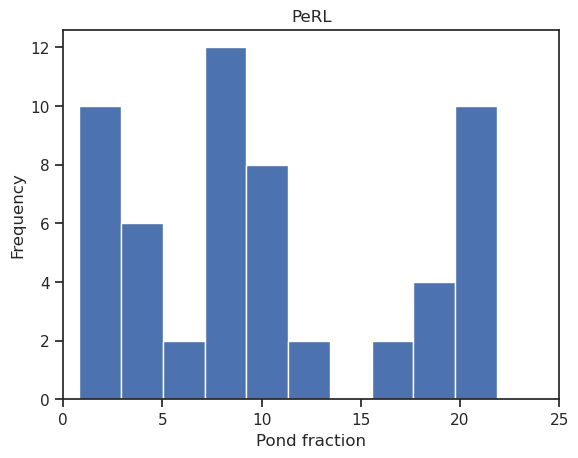

In [5]:
df_perl_ls.dropna().frac_ponds_norm.plot.hist()
plt.title('PeRL')
plt.xlabel('Pond fraction')
plt.xlim([0, 25])

# CIR LSD analysis

In [3]:
## Inputs
lsd_cir_pth = '/mnt/g/Planet-SR-2/Classification/cir/dcs_fused_hydroLakes_buf_10_sum.shp'
gdf_cir_lsd = pyogrio.read_dataframe(lsd_cir_pth, read_geometry=True, use_arrow=True)
gdf_cir_lsd.head()


,Join_Count,TARGET_FID,Area,RiverDomin,Category4,Region4,OID_,JOIN_FID,geometry
0,1,0,0.011819,0,1,12,1,0,"POLYGON ((-680953.719 1387817.517, -680953.420..."
1,1,1,0.006978,0,1,12,2,1,"POLYGON ((-681991.719 1387821.517, -681991.402..."
2,1,2,0.259890,0,1,12,3,2,"POLYGON ((-681504.361 1387932.796, -681503.668..."
3,1,3,0.001193,0,1,12,4,3,"POLYGON ((-680021.532 1387963.352, -680021.908..."
4,1,4,0.001669,0,1,12,5,4,"POLYGON ((-681108.187 1388031.354, -681108.719..."


In [4]:
gdf_cir_lsd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 43562 entries, 0 to 43561
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Join_Count  43562 non-null  int64   
 1   TARGET_FID  43562 non-null  int64   
 2   Area        43562 non-null  float64 
 3   RiverDomin  43562 non-null  int64   
 4   Category4   43562 non-null  int64   
 5   Region4     43562 non-null  int64   
 6   OID_        43562 non-null  int64   
 7   JOIN_FID    43562 non-null  int64   
 8   geometry    43562 non-null  geometry
dtypes: float64(1), geometry(1), int64(7)
memory usage: 3.0 MB


In [5]:
## Add region to gdf
regions = ['Sagavanirktok River', 'Yukon Flats Basin', 'Old Crow Flats', 'Mackenzie River Delta', 'Mackenzie River Valley', 'Canadian Shield Margin', 'Canadian Shield', 'Slave River', 'Peace-Athabasca Delta', 'Athabasca River', 'Prairie Potholes North', 'Prairie Potholes South', 'Tuktoyaktuk Peninsula', 'All']
# gdf_cir_lsd['Region'] = regions[gdf_cir_lsd['Region4']-2]
# gdf_cir_lsd.apply(Region = lambda x: x.Region4, axis=1) # (regions[x['Region4']-2]) # regions[x.Region4]
# gdf_cir_lsd['Region'].head()
for idx in gdf_cir_lsd.index: # slow, non-vectorized way...
    gdf_cir_lsd.loc[idx, 'Region'] = regions[gdf_cir_lsd.loc[idx, 'Region4']-2]
gdf_cir_lsd.head()

,Join_Count,TARGET_FID,Area,RiverDomin,Category4,Region4,OID_,JOIN_FID,geometry,Region
0,1,0,0.011819,0,1,12,1,0,"POLYGON ((-680953.719 1387817.517, -680953.420...",Prairie Potholes North
1,1,1,0.006978,0,1,12,2,1,"POLYGON ((-681991.719 1387821.517, -681991.402...",Prairie Potholes North
2,1,2,0.259890,0,1,12,3,2,"POLYGON ((-681504.361 1387932.796, -681503.668...",Prairie Potholes North
3,1,3,0.001193,0,1,12,4,3,"POLYGON ((-680021.532 1387963.352, -680021.908...",Prairie Potholes North
4,1,4,0.001669,0,1,12,5,4,"POLYGON ((-681108.187 1388031.354, -681108.719...",Prairie Potholes North


In [6]:
## Cycle through 14 regions and compute additional stats
df_cir_rec = pd.DataFrame(columns = ['Region_ID', 'Region', 'Lake_area', 'stat', 'A_0.001', 'A_0.001_cor', 'A_0.01_cor', 'A_0.01', 'A_g100m', 'A_g1', 'PeRL_pnd_f']) # cir recomputed, for double checking A_0.001 from paper; A_0.001_cor excludes the largest lakes like in PeRL, but uses native CIR min size of 40 m2; computing A_0.01 analogous to PeRL pond fraction, PeRL_pnd for equivalent to perl analysis (min is 100 m2, max is 1 km2), A_g100m, for lakes > 100 m2, analogous to PeRL, F_g1 for area of lakes larger than PeRL maximum size, 'PeRL_all' to simulate perl size domain, and 'PeRL_pnd_f' which is perl pond divided perl all # 'PeRL_pnd', 'PeRL_all'
for i, region in enumerate(range(2, 16)): # no region 1
    if region!=15: 
        gdf_tmp = gdf_cir_lsd.query('Region4 == @region')
    else:
        gdf_tmp = gdf_cir_lsd # compute over all
    df_cir_rec.loc[i, 'Region_ID'] = region
    df_cir_rec.loc[i, 'Region'] = regions[i]
    df_cir_rec.loc[i, 'Lake_area'] = gdf_tmp.Area.sum()
    df_cir_rec.loc[i, 'A_0.001'] = gdf_tmp.query('(Area < 0.001)').Area.sum() / df_cir_rec.loc[i, 'Lake_area'] * 100
    df_cir_rec.loc[i, 'A_0.001_cor'] = gdf_tmp.query('(Area < 0.001)').Area.sum() / gdf_tmp.query('(Area < 1)').Area.sum() * 100
    df_cir_rec.loc[i, 'A_0.01_cor'] = gdf_tmp.query('(Area < 0.01)').Area.sum() / gdf_tmp.query('(Area < 1)').Area.sum() * 100
    df_cir_rec.loc[i, 'A_0.01'] = gdf_tmp.query('(Area < 0.01)').Area.sum() / df_cir_rec.loc[i, 'Lake_area'] * 100
    df_cir_rec.loc[i, 'A_g1'] = gdf_tmp.query('(Area >= 1)').Area.sum() / df_cir_rec.loc[i, 'Lake_area'] * 100    
    df_cir_rec.loc[i, 'A_g100m'] = gdf_tmp.query('(Area >= 0.0001)').Area.sum() / df_cir_rec.loc[i, 'Lake_area'] * 100
    df_cir_rec.loc[i, 'PeRL_pnd_f'] = gdf_tmp.query('(Area >= 0.0001) and  (Area < 0.01)').Area.sum() / \
         gdf_tmp.query('(Area >= 0.0001) and  (Area < 1)').Area.sum() * 100
    df_cir_rec.loc[i, 'HL_pnd_f_4'] = gdf_tmp.query('(Area >= 0.0001) and  (Area < 0.1)').Area.sum() / \
        gdf_tmp.query('(Area >= 0.0001) and  (Area < 1)').Area.sum() * 100 # Pond fraction, as defined by HydroLakes lower limit and upper limit defined by CIR # 4 means that lower limit is 10^-4
    df_cir_rec.loc[i, 'HL_pnd_r_4'] = gdf_tmp.query('(Area >= 0.0001) and  (Area < 0.1)').Area.sum() / \
        gdf_tmp.query('(Area >= 0.1) and  (Area < 1)').Area.sum() * 100 # Pond fraction, as defined by HydroLakes lower limit and upper limit defined by CIR (fraction, not ratio, so it can be used as divident for extrapolation from mid lakes)
    df_cir_rec.loc[i, 'HL_pnd_r_3'] = gdf_tmp.query('(Area >= 0.001) and  (Area < 0.1)').Area.sum() / \
        gdf_tmp.query('(Area >= 0.1) and  (Area < 1)').Area.sum() * 100 # to compare to WBD
    df_cir_rec.loc[i, 'HL_pnd_r_2'] = gdf_tmp.query('(Area >= 0.01) and  (Area < 0.1)').Area.sum() / \
        gdf_tmp.query('(Area >= 0.1) and  (Area < 1)').Area.sum() * 100 # to compare to Sheng

## Re-index
df_cir_rec.set_index('Region', inplace=True)

## View
df_cir_rec[['A_0.001_cor', 'A_0.01', 'A_0.01_cor', 'PeRL_pnd_f', 'HL_pnd_r_4', 'HL_pnd_r_3', 'HL_pnd_r_2']]

,A_0.001_cor,A_0.01,A_0.01_cor,PeRL_pnd_f,HL_pnd_r_4,HL_pnd_r_3,HL_pnd_r_2
Region,,,,,,,
Sagavanirktok River,3.031203,10.395833,10.395833,10.185303,47.667000,43.527349,32.626669
Yukon Flats Basin,0.99283,5.839131,7.522919,7.472215,59.048881,57.556135,47.164407
Old Crow Flats,0.195526,0.654397,1.837864,1.825564,23.633221,23.406948,21.376218
Mackenzie River Delta,0.396733,2.067478,3.93086,3.907932,29.847743,29.363461,24.773382
Mackenzie River Valley,0.863484,1.176034,6.227916,6.160738,46.737951,45.575106,37.697809
Canadian Shield Margin,1.33229,0.197271,8.305,8.246269,48.053952,46.175011,35.845026
Canadian Shield,0.247682,0.191295,2.25814,2.239487,31.176905,30.876975,28.239215
Slave River,4.147409,17.321269,23.358883,23.093916,94.104852,86.697767,49.278441
Peace-Athabasca Delta,2.832858,1.03603,13.606928,13.368182,60.758854,56.636452,39.268317


Median pond fraction for CIR: 6.8164765870156145



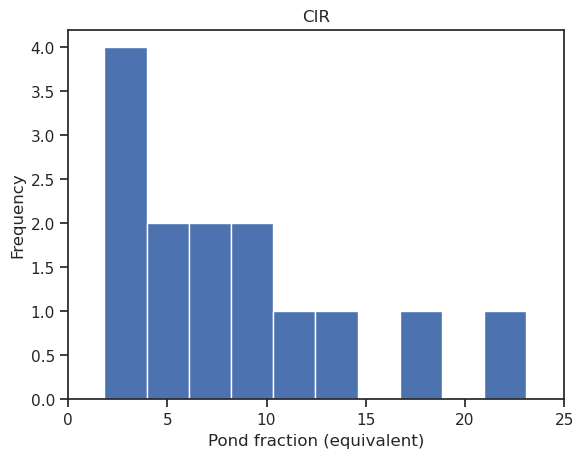

In [7]:
## CIR hist and calculate median pond fractions
df_cir_rec.PeRL_pnd_f.plot.hist()
plt.title('CIR')
plt.xlabel('Pond fraction (equivalent)')
plt.xlim([0, 25])
perl_pond_frac_cir = df_cir_rec.PeRL_pnd_f.median()
print(f'Median pond fraction for CIR: {perl_pond_frac_cir}')
# hl_pond_frac_cir = df_cir_rec.HL_pnd_f.median()
# print(f'Median HL pond fraction for CIR: {hl_pond_frac_cir}')
print('')

## CDF plots

### Plotting functions

In [ ]:
def findNearest(arr, val):
    ''' Function to find index of value nearest to target value'''
    # calculate the difference array
    difference_array = np.absolute(arr-val)
    
    # find the index of minimum element from the array
    index = difference_array.argmin()
    return index

In [ ]:
def plotECDFByValue(values, reverse=True, ax=None, **kwargs):
    '''Cumulative histogram by value (lake area), not count. Creates, but doesn't return fig, ax if they are not provided. By default, CDF order is reversed to emphasize addition of small lakes (flips over ahorizontal axis).'''
    if reverse:
        X = np.sort(values)[-1::-1] # highest comes first bc I reversed order
    else:
        X = np.sort(values)
    S = np.cumsum(X) # cumulative sum, starting with highest values
    if not ax:
        _, ax = plt.subplots()
    ax.plot(X, S/np.sum(X), **kwargs) 
    
    ## Viz params
    ax.set_xscale('log')
    ax.set_ylabel('Cumulative fraction of total area')
    ax.set_xlabel('Lake area')
    # return S

## Test
# plotECDFByValue(gdf_cir_lsd.Area)

### Plots

<AxesSubplot:xlabel='Area', ylabel='Density'>

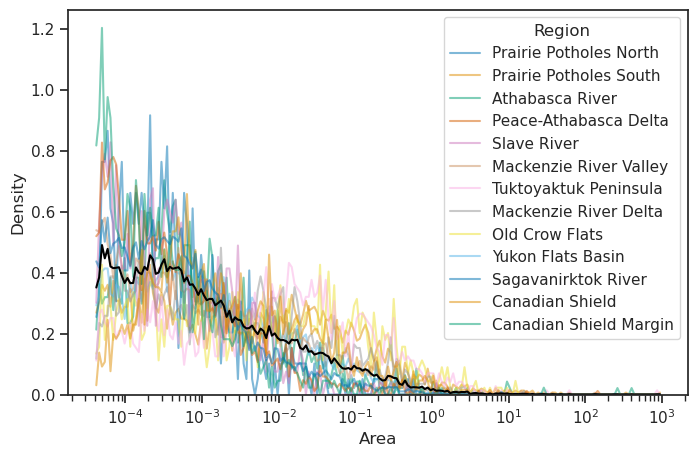

In [ ]:
## Binned PDF plot (V1)
fig, ax = plt.subplots(figsize=(8,5)) # size=(5,3)
sns.histplot(data=gdf_cir_lsd, x="Area", hue="Region", element="poly", log_scale=True, bins=200, palette=None, stat='density', cumulative=False, common_norm=False, fill=False, alpha=0.5, ax=ax) # 
sns.histplot(data=gdf_cir_lsd, x="Area", color='black', element="poly", log_scale=True, bins=200, palette=None, stat='density', cumulative=False, common_norm=False, fill=False, ax=ax, label='All') # 
# ax.set_yscale('log')

Text(0.5, 0, 'Lake area')

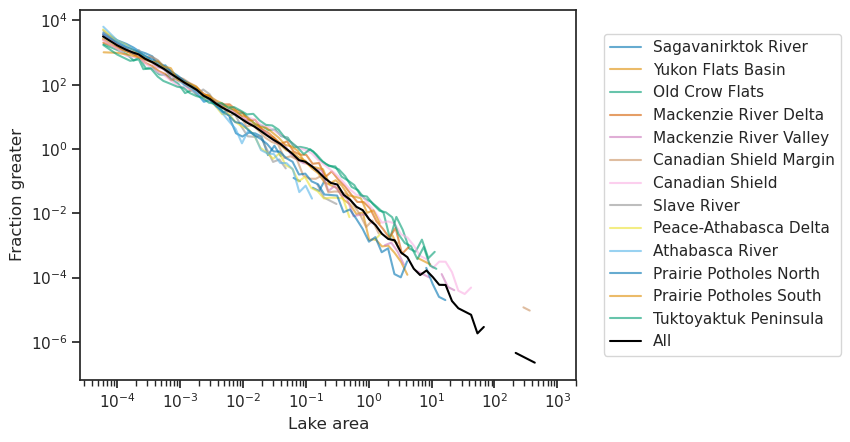

In [ ]:
## PDF v2: Powerlaw package plots:  PDF (no binning)

## colors
# rainbow_cycler = cycler
sns.set_palette("colorblind",len(regions) ) # colors from https://stackoverflow.com/a/46152327/7690975 Other option is: `from cycler import cycler; `# ax.set_prop_cycle(rainbow_cycler), plt(... prop_cycle=rainbow_cycler, )

## plot
fig, ax = plt.subplots() # figsize=(5,3)
for region in regions[:-1]:
    powerlaw.plot_pdf(gdf_cir_lsd.query('Region == @region').Area, alpha=0.6, ax=ax, label=region) # color='green' # 

powerlaw.plot_pdf(gdf_cir_lsd.Area, ax=ax, color='black', label='All')
ax.legend(loc= 'center left', bbox_to_anchor=(1.04, 0.5)) # legend on right (see https://stackoverflow.com/a/43439132/7690975)
ax.set_ylabel('Fraction')
ax.set_xlabel('Lake area')

<AxesSubplot:xlabel='Area', ylabel='Probability'>

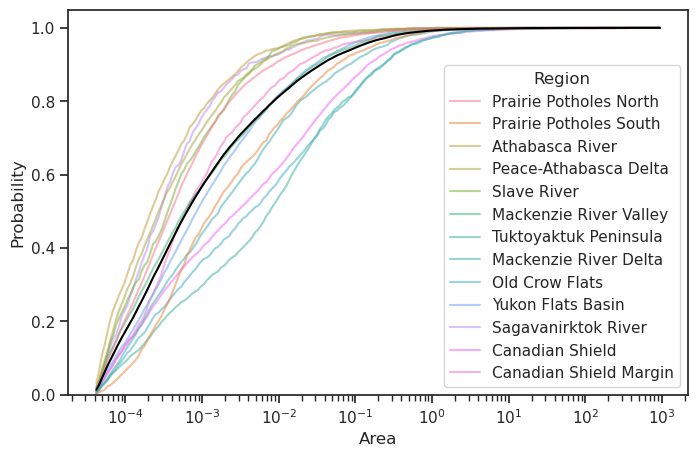

In [ ]:
## Binned CDF plot
fig, ax = plt.subplots(figsize=(8,5)) # size=(5,3)
sns.histplot(data=gdf_cir_lsd, x="Area", hue="Region", element="poly", log_scale=True, bins=200, palette=None, stat='probability', cumulative=True, common_norm=False, fill=False, alpha=0.5, ax=ax) # 
sns.histplot(data=gdf_cir_lsd, x="Area", color='black', element="poly", log_scale=True, bins=200, palette=None, stat='probability', cumulative=True, common_norm=False, fill=False, ax=ax, label='All') # 
# ax.set_yscale('log')

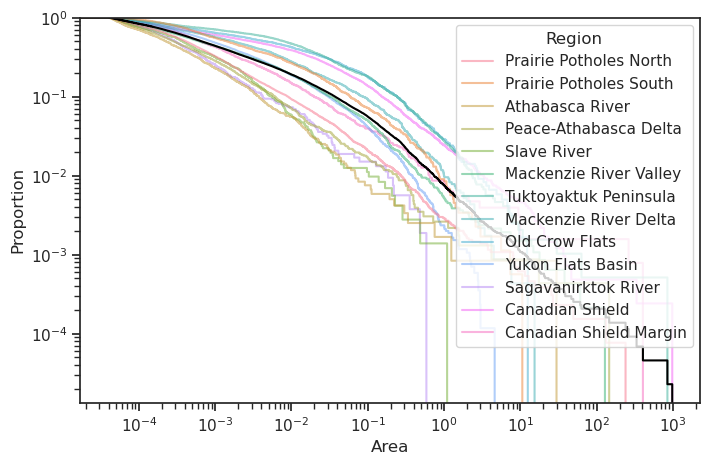

In [ ]:
## Non-binned Empirical CDF plot (sns says downside is "basic properties of the distribution (such as its central tendency, variance, and the presence of any bimodality) may not be as intuitive.")
fig, ax = plt.subplots(figsize=(8,5)) # size=(5,3)
sns.ecdfplot(data=gdf_cir_lsd, complementary=True, x="Area", hue="Region", log_scale=True, alpha=0.5, ax=ax) # 
sns.ecdfplot(data=gdf_cir_lsd, complementary=True, x="Area", color='black', log_scale=True, ax=ax, label='All') # 
ax.set_yscale('log')

Text(0.5, 0, 'Lake area')

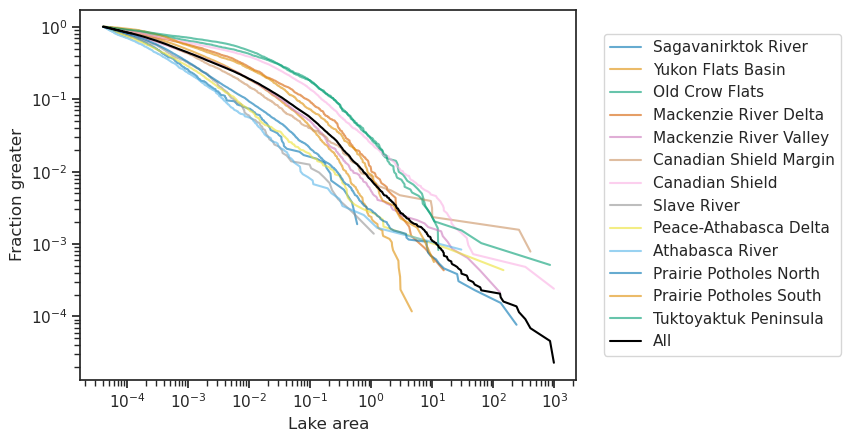

In [ ]:
## Powerlaw package plots: CDF also doesn't use binning and no annoying step plot

## colors
# rainbow_cycler = cycler
sns.set_palette("colorblind",len(regions) ) # colors from https://stackoverflow.com/a/46152327/7690975 Other option is: `from cycler import cycler; `# ax.set_prop_cycle(rainbow_cycler), plt(... prop_cycle=rainbow_cycler, )

## plot
fig, ax = plt.subplots() # figsize=(5,3)
for region in regions[:-1]:
    powerlaw.plot_cdf(gdf_cir_lsd.query('Region == @region').Area, alpha=0.6, survival=True, ax=ax, label=region) # color='green' # 

powerlaw.plot_cdf(gdf_cir_lsd.Area, survival=True, ax=ax, color='black', label='All')
ax.legend(loc= 'center left', bbox_to_anchor=(1.04, 0.5)) # legend on right (see https://stackoverflow.com/a/43439132/7690975)
ax.set_ylabel('Fraction greater')
ax.set_xlabel('Lake area')


Text(0.5, 0, 'Lake area')

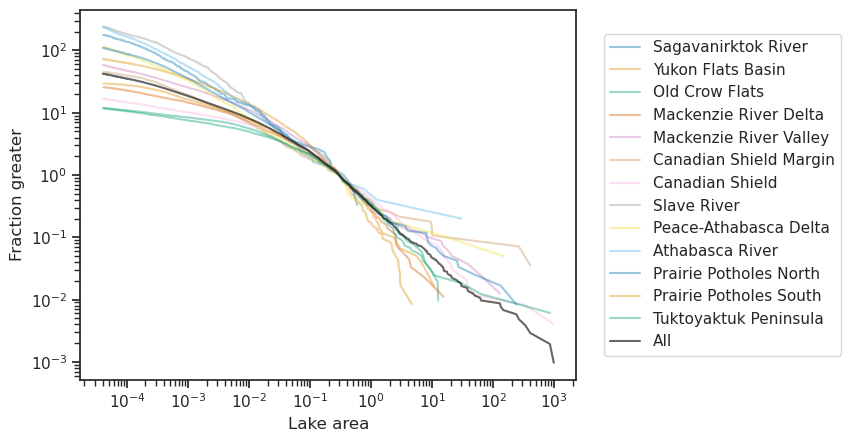

In [ ]:
## Repeat, but apply offset based on value at 0.3 km2 to match up on high end

## colors
# rainbow_cycler = cycler
sns.set_palette("colorblind",len(regions) ) # colors from https://stackoverflow.com/a/46152327/7690975 Other option is: `from cycler import cycler; `# ax.set_prop_cycle(rainbow_cycler), plt(... prop_cycle=rainbow_cycler, )

## plot
fig, ax = plt.subplots() # figsize=(5,3)
for region in regions[:-1]:
    X, P = powerlaw.cdf(gdf_cir_lsd.query('Region == @region').Area, survival=True) # color='green' # 
    idx = findNearest(X, 0.3)
    ax.plot(X, P/(P[idx]), alpha=0.4, label=region)

## repeat for all (should re-use as function...)
X, P = powerlaw.cdf(gdf_cir_lsd.Area, survival=True)
idx = findNearest(X, 0.3)
ax.plot(X, P/(P[idx]), alpha=0.6, color='black', label='All')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc= 'center left', bbox_to_anchor=(1.04, 0.5)) # legend on right (see https://stackoverflow.com/a/43439132/7690975)
ax.set_ylabel('Fraction greater')
ax.set_xlabel('Lake area')

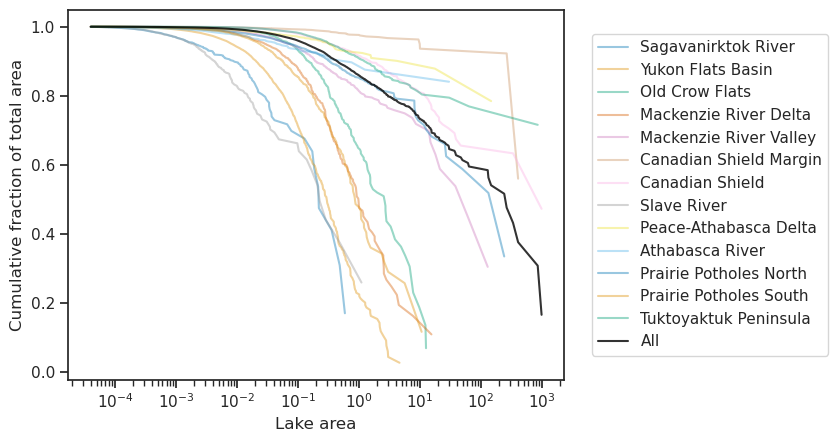

In [ ]:
## Cumulative histogram by value (lake area), not count

## colors
# rainbow_cycler = cycler
sns.set_palette("colorblind",len(regions) ) # colors from https://stackoverflow.com/a/46152327/7690975 Other option is: `from cycler import cycler; `# ax.set_prop_cycle(rainbow_cycler), plt(... prop_cycle=rainbow_cycler, )

## plot
fig, ax = plt.subplots() # figsize=(5,3)
for region in regions[:-1]:
    plotECDFByValue(gdf_cir_lsd.query('Region == @region').Area, ax=ax, alpha=0.4, label=region)

## repeat for all
plotECDFByValue(gdf_cir_lsd.Area, ax=ax, alpha=0.8, color='black', label='All')
ax.legend(loc= 'center left', bbox_to_anchor=(1.04, 0.5)) # legend on right (see https://stackoverflow.com/a/43439132/7690975)

# Calculate means and uncertainties for pond percentage from BAWLD

In [8]:
df_cir_rec

,Region_ID,Lake_area,stat,A_0.001,A_0.001_cor,A_0.01_cor,A_0.01,A_g100m,A_g1,PeRL_pnd_f,HL_pnd_f_4,HL_pnd_r_4,HL_pnd_r_3,HL_pnd_r_2
Region,,,,,,,,,,,,,,
Sagavanirktok River,2,3.468144,NaN,3.031203,3.031203,10.395833,10.395833,99.765595,0.0,10.185303,32.280063,47.667000,43.527349,32.626669
Yukon Flats Basin,3,178.651695,NaN,0.770614,0.99283,7.522919,5.839131,99.957466,22.382112,7.472215,37.126247,59.048881,57.556135,47.164407
Old Crow Flats,4,184.341128,NaN,0.06962,0.195526,1.837864,0.654397,99.995539,64.393612,1.825564,19.115591,23.633221,23.406948,21.376218
Mackenzie River Delta,5,142.371405,NaN,0.208666,0.396733,3.93086,2.067478,99.98745,47.403939,3.907932,22.986725,29.847743,29.363461,24.773382
Mackenzie River Valley,6,423.789104,NaN,0.163054,0.863484,6.227916,1.176034,99.986482,81.116737,6.160738,31.851304,46.737951,45.575106,37.697809
Canadian Shield Margin,7,724.885218,NaN,0.031646,1.33229,8.305,0.197271,99.99848,97.624667,8.246269,32.457055,48.053952,46.175011,35.845026
Canadian Shield,8,2082.631846,NaN,0.020982,0.247682,2.25814,0.191295,99.998384,91.528632,2.239487,23.767069,31.176905,30.876975,28.239215
Slave River,9,4.248273,NaN,3.07542,4.147409,23.358883,17.321269,99.744519,25.847187,23.093916,48.481453,94.104852,86.697767,49.278441
Peace-Athabasca Delta,10,186.61657,NaN,0.215694,2.832858,13.606928,1.03603,99.979017,92.386008,13.368182,37.795028,60.758854,56.636452,39.268317


In [9]:
def weightedStd(x, w):
    '''Computes standard deviation of values given as group means x, with weights w'''
    return np.sqrt((np.average((x-np.average(x, weights=w, axis=0))**2, weights=w, axis=0)).astype('float'))

## Test
# weightedStd(df_cir_rec.drop(index='All')['HL_pnd_r_2'], df_cir_rec.drop(index='All')['Lake_area'])
# weightedStd(df_cir_rec.drop(index='All')[ratio_cols], df_cir_rec.drop(index='All')['Lake_area'])

In [10]:
## Lookup table with ratios for extrapolation
# ratio_table = {
#     'HL_pnd_r_4': df_cir_rec.loc[ 'All', 'HL_pnd_r_4'],
#     'HL_pnd_r_3': df_cir_rec.loc[ 'All', 'HL_pnd_r_3'],
#     'HL_pnd_r_2': df_cir_rec.loc[ 'All', 'HL_pnd_r_2']
#     }
ratio_cols = ['HL_pnd_r_4', 'HL_pnd_r_3', 'HL_pnd_r_2']
ratio_table = pd.DataFrame({
    'All': df_cir_rec.loc['All', 'HL_pnd_r_4':'HL_pnd_r_2'],
    'Std': weightedStd(df_cir_rec.drop(index='All')[ratio_cols], df_cir_rec.drop(index='All')['Lake_area']), # [:, 'HL_pnd_r_4':'HL_pnd_r_2']
    'Std_unwt': df_cir_rec.drop(index='All')[ratio_cols].std(), # unweighted std dev (dont use)
    'Quant5': df_cir_rec.drop(index='All')[ratio_cols].quantile(0.05),
    'Quant95': df_cir_rec.drop(index='All')[ratio_cols].quantile(0.95)}) 

## Pre-add/subt to get upper and lower values based on std, for simplicity and thrift later on
ratio_table['Lower'] = ratio_table.All - ratio_table.Std
ratio_table['Upper'] = ratio_table.All + ratio_table.Std
ratio_table

,All,Std,Std_unwt,Quant5,Quant95,Lower,Upper
HL_pnd_r_4,39.865731,15.252170,27.423626,23.446645,103.182303,24.613561,55.117901
HL_pnd_r_3,38.777844,13.905687,24.606605,23.245031,94.895595,24.872157,52.683531
HL_pnd_r_2,32.451407,9.067662,15.149321,21.101484,60.640909,23.383745,41.519069


In [11]:
## Load grid and lake gdfs
gdf = pyogrio.read_dataframe(gdf_bawld_pth, read_geometry=True, use_arrow=True) # grid cells
df = pyogrio.read_dataframe(gdf_HL_jn_pth, columns=['BAWLDCell_', 'Shp_Area', 'BAWLDLong', 'BAWLDLat'], read_geometry=False, use_arrow=True) # lakes (load as df to save mem)
print(df.head(2))
print(gdf.head(2))

   Shp_Area  BAWLDCell_  BAWLDLong  BAWLDLat
0  30450.64       11887    -122.25     65.75
1  26734.29        7387    -113.25     61.75
   Cell_ID    Long    Lat  Area_Pct      Shp_Area  GLA    ROC    TUN    BOR  \
0     7265  165.75  61.25     100.0  1.495458e+09  0.0  35.26  48.78  14.92   
1    14494   61.25  67.75     100.0  1.178664e+09  0.0   0.00  64.31   0.00   

     WET  ...  RIV_L  RIV_H  LAR_L  LAR_H  SRR_L  SRR_H  SRP_L  SRP_H  \
0   0.80  ...   0.09   0.24    0.0    0.0   0.00   0.05   0.23   0.39   
1  32.04  ...   0.14   0.38    0.0    0.0   0.01   0.28   0.00   0.12   

   WETSCAPE                                           geometry  
0        11  POLYGON ((774650.577 3106953.763, 801734.023 3...  
1         1  POLYGON ((2193307.808 -1190868.976, 2182832.13...  

[2 rows x 73 columns]


In [12]:
# Loop over grid cells (TODO: rewrite as a map or map_async)
for i in tqdm(range(len(gdf))): # 10 # len(gdf)
    ## Select only lakes in cell (based on pour point)
    cell_id = gdf.loc[i, 'Cell_ID'] # called BAWLD_Cell in df
    df_tmp = df.query(f'BAWLDCell_==@cell_id')

    ## compute area stats
    gdf.loc[i, 'HL_area'] = df_tmp.Shp_Area.sum() # all HL-observable lakes
    gdf.loc[i, 'Ppnd_area'] = df_tmp.query('(Shp_Area >= 0.0001) and  (Shp_Area < 0.01)').Shp_Area.sum() # perl ponds (will always be 0 for HL)
    gdf.loc[i, 'Plk_area'] = df_tmp.query('(Shp_Area >= 0.01) and  (Shp_Area < 1)').Shp_Area.sum() # perl lakes (not ponds)
    gdf.loc[i, 'Mid_lk_area'] = df_tmp.query('(Shp_Area >= 0.1) and  (Shp_Area < 1)').Shp_Area.sum() # Mid lakes (if I used 0.3 cutoff, I could include all CIR sites) to use for extrapolation
    gdf.loc[i, 'Lg_lk_area'] = df_tmp.query('(Shp_Area >= 1)').Shp_Area.sum() # Large lakes (add to extrapolation)
    gdf.loc[i, 'Hpnd_extrap4'] = (1 + ratio_table.loc['HL_pnd_r_4', 'All'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Extrap4_l'] = (1 + ratio_table.loc['HL_pnd_r_4', 'Lower'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Extrap4_u'] = (1 + ratio_table.loc['HL_pnd_r_4', 'Upper'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Extrap3'] = (1 + ratio_table.loc['HL_pnd_r_3', 'All'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Extrap3_l'] = (1 + ratio_table.loc['HL_pnd_r_3', 'Lower'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Extrap3_u'] = (1 + ratio_table.loc['HL_pnd_r_3', 'Upper'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Extrap2'] = (1 + ratio_table.loc['HL_pnd_r_2', 'All'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Extrap2_l'] = (1 + ratio_table.loc['HL_pnd_r_2', 'Lower'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Extrap2_u'] = (1 + ratio_table.loc['HL_pnd_r_2', 'Upper'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Meg_lk_area'] = df_tmp.query('(Shp_Area >= 5000)').Shp_Area.sum() # Mega lakes (often subtracted from upscaling)

gdf.head()

100%|██████████| 23469/23469 [04:39<00:00, 84.09it/s]


,Cell_ID,Long,Lat,Area_Pct,Shp_Area,GLA,ROC,TUN,BOR,WET,...,Hpnd_extrap4,Hpnd_extrap4_l,Hpnd_extrap4_u,Hpnd_extrap3,Hpnd_extrap3_l,Hpnd_extrap3_u,Hpnd_extrap2,Hpnd_extrap2_l,Hpnd_extrap2_u,Meg_lk_area
0,7265,165.75,61.25,100.00,1.495458e+09,0.0,35.26,48.78,14.92,0.80,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,14494,61.25,67.75,100.00,1.178664e+09,0.0,0.00,64.31,0.00,32.04,...,9.510953,9.391986,9.629920,9.502467,9.394003,9.610932,9.453121,9.382393,9.523849,0.0
2,3598,51.25,57.25,42.39,7.103697e+08,0.0,0.00,0.00,91.04,8.81,...,0.461557,0.411225,0.511889,0.457967,0.412078,0.503856,0.437090,0.407166,0.467013,0.0
3,4863,122.25,58.75,100.00,1.612116e+09,0.0,0.00,0.00,96.13,3.72,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,19124,-99.25,73.25,100.00,8.978315e+08,0.0,31.62,63.32,0.00,2.96,...,20.549300,19.788217,21.310383,20.495014,19.801121,21.188908,20.179325,19.726849,20.631802,0.0


In [13]:
## Write out
gdf.to_csv(area_extrap_pth)

In [14]:
## Skip analysis and load
# gdf = pd.read_csv(area_extrap_pth)
# !csv {area_extrap_pth}
!head -n 2 {area_extrap_pth} | column -s, -t 

Cell_ID  Long  Lat     Area_Pct  Shp_Area  GLA           ROC  TUN    BOR    WET    PEB  WTU   MAR   BOG   FEN  LAK   LAL  MPL  MYL  MGL  SPL  SYL  SGL  RIV  LAR   SRR  SRP  GLA_L  GLA_H  ROC_L  ROC_H  TUN_L  TUN_H  BOR_L  BOR_H  WET_L  WET_H  PEB_L  PEB_H  WTU_L  WTU_H  MAR_L  MAR_H  BOG_L  BOG_H  FEN_L  FEN_H  LAK_L  LAK_H  LAL_L  LAL_H  MPL_L  MPL_H  MYL_L  MYL_H  MGL_L  MGL_H  SPL_L  SPL_H  SYL_L  SYL_H  SGL_L  SGL_H  RIV_L  RIV_H  LAR_L  LAR_H  SRR_L  SRR_H  SRP_L  SRP_H  WETSCAPE  geometry  HL_area                                          Ppnd_area                              Plk_area                         Mid_lk_area                            Lg_lk_area                                Hpnd_extrap4  Hpnd_extrap4_l  Hpnd_extrap4_u  Hpnd_extrap3  Hpnd_extrap3_l  Hpnd_extrap3_u  Hpnd_extrap2  Hpnd_extrap2_l  Hpnd_extrap2_u  Meg_lk_area
0        7265  165.75  61.25     100.0     1495458177.0  0.0  35.26  48.78  14.92  0.8  0.48  0.09  0.05  0.0  0.18  0.0  0.0  0.0  0.0  0.0  0.0  

/tmp/ipykernel_23509/939897170.py:3: FutureWarning: The default value of numeric_only in GeoDataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sums = gdf.sum()


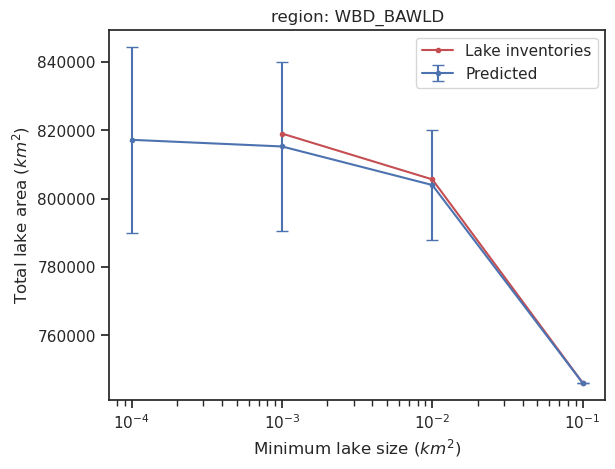

In [112]:
## Plot total area as function of extrapolated min. size

sums = gdf.sum()
plt.errorbar([0.1, 0.01, 0.001, 0.0001], [sums.HL_area, sums.Hpnd_extrap2, sums.Hpnd_extrap3, sums.Hpnd_extrap4],
    yerr=[0, sums.Hpnd_extrap2-sums.Hpnd_extrap2_l, sums.Hpnd_extrap3-sums.Hpnd_extrap3_l, sums.Hpnd_extrap4-sums.Hpnd_extrap4_l],
    capsize=4, fmt='.-b', label='Predicted')
plt.plot([0.1, 0.01, 0.001], [746137.7599999998, 805675.0937146356, 819091.9657548245], '.-r', label='Lake inventories') # Paste summed values from lake databases here
plt.xscale('log')
plt.xlabel('Minimum lake size ($km^2$)')
plt.ylabel('Total lake area ($km^2$)')
plt.title(f'region: {roi_region}')
plt.legend()

TODO: 
* make equivalence to hl_pond_frac_cir x
* [try using numba to accelerate?]
* save 1 vs. 0.3 cutoff as var 
* add std or CI x
* write out x
* find a way to relate to flux estimates

# HR16 scaling

In [3]:
## Inputs
lsd_pth='/mnt/d/GoogleDrive/Research/Lake distributions/savedData/fitting_data_regional_4_det.mat' # these directories hold the final version of data used for 2019 paper
lsd_labels_pth='/mnt/d/GoogleDrive/Research/Lake distributions/regionLabels4.mat'

In [7]:
# fluxes={'OW': 100,
#        'GW': 300,
#        'SW': 200}

FRACTION={
    'IN_TOTAL':(
    (22, 31),
    (10,16),
    (27, 30),
    (37.4, 37.6),
    (10, 37.6)), # Default Fraction Inundated; From Run 35
    'EM':((35, 58),
     (42, 60),
     (12, 21),
     (2, 2.5),
     (0, 100)) #(2, 30) # Default Fraction macrophyte: From Run 35 (range: 2:60)
}
FLUXES={
    'OW': (0, 166), # Open water; From range in: Burger et al 2016	Biogeosciences | Superceded if using LSD
    'EM': (77, 2000), # (77, 3000) #(77, 380)  # Emergent macrophyte; From mean (max = 5800) in: Burger et al 2016	Biogeosciences
    'RATIO': (0, 4000) # based on second and third- highest values of ~170x (0, 200)
}
    # Sensitivity raster dimensions
FRACTION_STEPS=100 # 40
FLUX_STEPS=100 # 40
SITES=('PAD','YFB','YKN','DAR','All') #short names for sites
SITES_LSD = (9,2,7,7,0) # numbers as givin in Lake Size Distribution files
# REGION=0 # Set to -1 if using default; 0=PAD

# LAT=59 # latitude, in degrees (PAD=59)

### Size binning data from Holgerson and Raymond 2016

In [9]:
BIN_EDGES=np.array([0, 0.001, 0.01, 0.1, 1, 10, 100, 1000000]) # <km2>
# BIN_EDGES=np.array([0.001, 0.01, 0.1, 1, 10, 100, 10000000]) * 1000000 # <km2> * 1000000 = <m2>
BIN_FLUXES=np.array([2.28, 0.65, 0.28, 0.16,  0.12, 0.10, 0.06])*16.043 # <mmolC (in CH4)/m2/d> * 16.043 = <mg CH4/m2/d>
len(BIN_FLUXES)

7

### Load data

In [10]:
fused_regional=loadmat(lsd_pth, variable_names='Fused_regional', squeeze_me=True)

##############
# for area for each region, see: D:\GoogleDrive\Research\Lake distributions\savedData\out
##############

### Create sensitivity raster

In [11]:
SENSITIVITY={}
FRACTION_POSTINGS={}
FLUX_POSTINGS={}
for si, s in enumerate(SITES):
    print('\nSite: {}'.format(s))
    lsd = fused_regional['Fused_regional'][SITES_LSD[si]] # Lake size distribution for chosen region
    SENSITIVITY[s]=np.zeros((FRACTION_STEPS, FLUX_STEPS), 'double') # init
    # lsd_tmp=lsd # init
    FRACTION_POSTINGS[s]=np.linspace(FRACTION['EM'][si][0], FRACTION['EM'][si][1], FRACTION_STEPS)
    for Class in FLUXES.keys():
        FLUX_POSTINGS[Class]=np.linspace(FLUXES[Class][0], FLUXES[Class][1], FLUX_STEPS)
    lsd_vals = binned_statistic(lsd, lsd, statistic='sum', bins=BIN_EDGES)
    ow_flux_mean=np.sum(lsd_vals.statistic*BIN_FLUXES)/lsd.sum()
    print(f'Open water flux used: {ow_flux_mean:.3} [mg CH_4 / m^2 / day]')
    print(f'EM fraction: {0:0.2f}%\t| Total W area in first bin: \t\
        {lsd_vals.statistic[0]*(100- 0)/100:.2f}\t| Total W area: {np.sum(lsd)*(100- 0)/100:.2f}\n')
    for i in range(FRACTION_STEPS):
        ##############################################
             # toggle if not using LSD
    #     ow_flux_mean=np.mean(FLUX_POSTINGS['OW'])
        ##############################################
            # toggle if using LSD | with lakes changing bins # Results in higher water flux in highest EM bin bc more of the lakes are now small (unrealistic)
    #     lsd_tmp_vals = binned_statistic(lsd_tmp, lsd_tmp, statistic='sum', bins=BIN_EDGES) # could also use np.digitize
    #     ow_flux_mean=np.sum(lsd_tmp_vals.statistic*BIN_FLUXES)/lsd_tmp.sum()
    #     print(f'EM fraction: {FRACTION_POSTINGS[i]:0.2f}%\t| Total W area in first bin: \
    #         {lsd_tmp_vals.statistic[0]:.2f}\t| Total W area: {np.sum(lsd_tmp_vals.statistic):.2f}\t| Total W flux: {((100- FRACTION_POSTINGS[i]) * ow_flux_mean) / 100:.2f}')
        ##############################################
            # toggle if using LSD | with lakes NOT changing bins # Results in lower water flux in highest EM bin
        print(f'EM fraction: {FRACTION_POSTINGS[s][i]:0.2f}%\t| Total W area in first bin: \
            {lsd_vals.statistic[0]*(100- FRACTION_POSTINGS[s][i])/100:.2f}\t| Total W area: \
            {np.sum(lsd_vals.statistic)*(100- FRACTION_POSTINGS[s][i])/100:.2f}\t| Total W flux: {((100- FRACTION_POSTINGS[s][i]) * ow_flux_mean) / 100:.2f}')
        ##############################################
        for j in range(FLUX_STEPS):
            # each cell = <region's inundation fraction> * (<EM fraction> * <EM flux> + <OW fraction> * <OW flux>)
            SENSITIVITY[s][i,j] = np.mean(FRACTION['IN_TOTAL'][si]) / 100 * (FRACTION_POSTINGS[s][i] * FLUX_POSTINGS['EM'][j] + # use median? # note: hard-coded for just two classes: OW and EM
                                (100- FRACTION_POSTINGS[s][i]) * ow_flux_mean) / 100
        


Site: PAD
Open water flux used: 1.36 [mg CH_4 / m^2 / day]
EM fraction: 0.00%	| Total W area in first bin: 	        0.40	| Total W area: 186.62

EM fraction: 35.00%	| Total W area in first bin:             0.26	| Total W area:             121.30	| Total W flux: 0.89
EM fraction: 35.23%	| Total W area in first bin:             0.26	| Total W area:             120.87	| Total W flux: 0.88
EM fraction: 35.46%	| Total W area in first bin:             0.26	| Total W area:             120.43	| Total W flux: 0.88
EM fraction: 35.70%	| Total W area in first bin:             0.26	| Total W area:             120.00	| Total W flux: 0.88
EM fraction: 35.93%	| Total W area in first bin:             0.26	| Total W area:             119.57	| Total W flux: 0.87
EM fraction: 36.16%	| Total W area in first bin:             0.26	| Total W area:             119.13	| Total W flux: 0.87
EM fraction: 36.39%	| Total W area in first bin:             0.26	| Total W area:             118.70	| Total W flux: 0.87


(0.0, 1000.0)

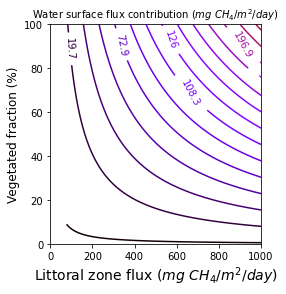

In [13]:
## Single contour plot
# %matplotlib inline
f=12 # fontsize
# num_contours = np.linspace(5, np.max(SENSITIVITY['All']), 11) #10
num_contours = np.linspace(2, 250, 15) #10

# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
    # axis
fig, ax = plt.subplots(sharex=True, figsize=(4,4))

    # quick fix
# quick_title=SITES # keep unchanged
quick_title=['PAD','YF','CS-1','CS-2','All'] # keep unchanged

    # loop
for si, s in zip([4], ['All']):
        
        # define dims
    Y=FRACTION_POSTINGS[s]
    X=FLUX_POSTINGS['EM']
    Z=SENSITIVITY[s]
    
    # Basic contour plot
    CS = ax.contour(X, Y, Z, num_contours, cmap='gnuplot', vmin =0, vmax=500,
        extent=(FLUXES['EM'][0], FLUXES['EM'][1], FRACTION['EM'][si][0], FRACTION['EM'][si][1]))

    # Recast levels to new class
    CS.levels = [nf(val) for val in CS.levels]

    # Label levels with specially formatted floats
    if plt.rcParams["text.usetex"]:
        fmt = r'%r'
    else:
        fmt = '%r'
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
    ax.set_xlabel("Littoral zone flux ($mg\ CH_4 / m^2 /day$)", fontsize=f+2)
    ax.set_ylabel('Vegetated fraction (%)', fontsize=f)
#     fig.text(0.5, 0.04, "Littoral zone flux ($mg\ CH_4 / m^2 /day$)", ha='center', va='bottom', fontsize=f, FONTNAME='DejaVu Sans')
#     fig.text(0.04, 0.5, 'Vegetated fraction (%)', va='center', rotation='vertical', fontsize=f, FONTNAME='sans-serif')
#     ax.set_title(f'{quick_title[si]}: {np.mean(SENSITIVITY[s]):0.0f}', fontsize=f)
    fig.tight_layout()
    
## Superimpose errorbar plot: lit values
# ax.errorbar(FLUXES_LIT, FRACTION_LIT, FRACTION_LIT_CI,FLUXES_LIT_CI, 'ko', ecolor='gray', fillstyle='none', alpha=0.6) # , clip_box=(0,0,6000,100)

## Superimpose errorbar plot: field values
# ax.errorbar(FLUXES_FIELD, FRACTION_FIELD, FRACTION_FIELD_CI,FLUXES_FIELD_CI, 'bo', ecolor='#2D7DC4', fillstyle='none', alpha=0.6) # , clip_box=(0,0,6000,100)

## title
plt.title('Water surface flux contribution ($mg\ CH_4 / m^2 /day$)', fontsize=f-2)

## legend
# plt.legend(['Published data', 'Field data'], loc='best')

## set window
ax.set_xlim(0, 1000)

    # save
# figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursErrors.jpg'
# plt.savefig(figPth, dpi=300)
# figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursErrors.pdf'
# plt.savefig(figPth, dpi=300)

# print('Saved fig to:\t{}'.format(figPth))